In [1]:
# ! pip install torchvision

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms
from torchvision.datasets import MNIST, CIFAR10, CIFAR100
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

In [3]:
path = './datasets/'

transform = transforms.Compose([transforms.ToTensor()])

#### HERE ####
train_data = MNIST(root=path, train=True, transform=transform, download=True)
test_data = MNIST(root=path, train=False, transform=transform, download=True)

batch_size = 128

#### HERE ####
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=1)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=1)

print(train_data)
print(test_data)

input_shape = train_data[0][0].reshape(-1).shape[0]
output_shape = len(train_data.classes)

print(input_shape, output_shape)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./datasets/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./datasets/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )
784 10


In [4]:
class SoftmaxClassifier(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()

        self.linear1 = nn.Linear(input_size, 64)
        self.linear2 = nn.Linear(64, 64)
        self.linear3 = nn.Linear(64, 64)
        self.linear4 = nn.Linear(64, output_size)

    def forward(self,x):

        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = F.softmax(self.linear4(x), -1)

        return x

In [5]:
if torch.backends.mps.is_available():
    device = torch.device("mps:0")
elif torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu:0")

print(device)

model = SoftmaxClassifier(28*28, 10).to(device)
loss = nn.CrossEntropyLoss()

# minimize loss
# minimize loss' = loss + weight_decay * l2_regularization
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3, weight_decay=0.001)

mps:0


In [6]:
num_epoch = 100
train_loss_list, test_loss_list = list(), list()

for i in range(num_epoch):
    
    ## train
    total_loss = 0
    count = 0

    for batch_idx, (x, y) in enumerate(train_loader):
        # MNIST: x.shape = (100,784), y.shape = (100,1) = (100,)

        # model 위치 이동 . 데이터 처리 
        x = x.reshape(-1, x.shape[-2]*x.shape[-1])
        x, y = x.to(device), y.to(device)

        # 순전파 
        pred = model(x)
        cost = loss(pred, y)

        total_loss += cost.item()
        count += (torch.argmax(pred, dim=1) == y).sum()

        # 역전파 
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
    acc = count/len(train_data)
    ave_loss = total_loss/len(train_data)

    train_loss_list.append(ave_loss)

    if i % 1 == 0:
        print("\nEpoch %d Train: %.3f / %.3f"%(i,ave_loss,acc))

    ## test
    total_loss = 0
    count = 0

    #### HERE ####
    for idx, (x,y) in enumerate(test_loader):
        x = x.reshape(-1, x.shape[-2]*x.shape[-1])
        x, y = x.to(device), y.to(device)

        with torch.no_grad():
            pred = model(x)
            cost = loss(pred, y)

        total_loss += cost.item()
        count += (torch.argmax(pred, dim=1) == y).sum()
    
    acc = count / len(test_data)
    ave_loss = total_loss/len(test_data)

    test_loss_list.append(ave_loss)

    if i % 1 == 0:
       print("Epoch %d Test: %.3f / %.3f"%(i,ave_loss,acc))


Epoch 0 Train: 0.014 / 0.739
Epoch 0 Test: 0.013 / 0.887

Epoch 1 Train: 0.012 / 0.906
Epoch 1 Test: 0.012 / 0.920

Epoch 2 Train: 0.012 / 0.930
Epoch 2 Test: 0.012 / 0.942

Epoch 3 Train: 0.012 / 0.942
Epoch 3 Test: 0.012 / 0.946

Epoch 4 Train: 0.012 / 0.950
Epoch 4 Test: 0.012 / 0.952

Epoch 5 Train: 0.012 / 0.952
Epoch 5 Test: 0.012 / 0.948

Epoch 6 Train: 0.012 / 0.956
Epoch 6 Test: 0.012 / 0.960

Epoch 7 Train: 0.012 / 0.959
Epoch 7 Test: 0.012 / 0.956

Epoch 8 Train: 0.012 / 0.962
Epoch 8 Test: 0.012 / 0.961

Epoch 9 Train: 0.012 / 0.963
Epoch 9 Test: 0.012 / 0.961

Epoch 10 Train: 0.012 / 0.964
Epoch 10 Test: 0.012 / 0.962

Epoch 11 Train: 0.012 / 0.965
Epoch 11 Test: 0.012 / 0.960

Epoch 12 Train: 0.012 / 0.966
Epoch 12 Test: 0.012 / 0.961

Epoch 13 Train: 0.012 / 0.967
Epoch 13 Test: 0.012 / 0.966

Epoch 14 Train: 0.012 / 0.968
Epoch 14 Test: 0.012 / 0.963

Epoch 15 Train: 0.012 / 0.969
Epoch 15 Test: 0.012 / 0.962

Epoch 16 Train: 0.012 / 0.968
Epoch 16 Test: 0.012 / 0.969


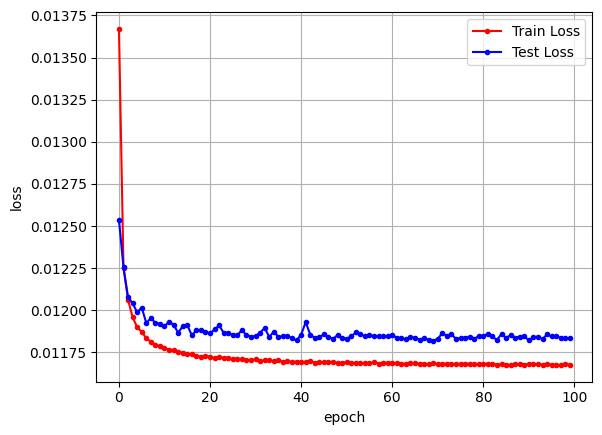

In [7]:
x_len = np.arange(len(train_loss_list))
plt.plot(x_len, train_loss_list, marker='.', c='red', label="Train Loss")
plt.plot(x_len, test_loss_list, marker='.', c='blue', label="Test Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [8]:
num_parameter = 0
for parameter in model.parameters():
    print(parameter.shape)
    num_parameter += np.prod(parameter.size())
print(num_parameter)

torch.Size([64, 784])
torch.Size([64])
torch.Size([64, 64])
torch.Size([64])
torch.Size([64, 64])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])
59210
